# Online Retail Data Set 

** Abstract **: This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.

### Data Set Characteristics:  

1. Multivariate, Sequential, Time-Series
2. Number of Instances: 541909
3. Area: Business
4. Attribute Characteristics: Integer, Real
5. Number of Attributes: 8
6. Date Donated: 2015-11-06
7. Associated Tasks: Classification, Clustering


#### Source: 
Dr Daqing Chen, Director: Public Analytics group. chend '@' lsbu.ac.uk, School of Engineering, London South Bank University, London SE1 0AA, UK.


#### Data Set Information:

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.


#### Attribute Information:

1. InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 
2. StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. 
3. Description: Product (item) name. Nominal. 
4. Quantity: The quantities of each product (item) per transaction. Numeric.	
5. InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated. 
6. UnitPrice: Unit price. Numeric, Product price per unit in sterling. 
7. CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. 
8. Country: Country name. Nominal, the name of the country where each customer resides.

<hr>
## Business Problem :

#### Problem statement: The goal is to come up with a solution for the given questions:

1. Can we categorize the customers in a particular segment based on their buying patterns? (Customer Segmentation)

2. Can we predict which kind of items they will buy in future based on their segmentation? (Prediction)

<hr>

## ML Problem Mapping.

1. Given a dataset of transanctions (Online Retail dataset from UCI Machine Learning repository) get the segments i.e clusters/segments. (Find common patterns and group them)
2. Predict what to display to what group of users

** Input: ** We will be using e-commerce data that contains the list of purchases in 1 year for 4,000 customers.

** Output: ** The first goal is that we need to categorize our consumer base into appropriate customer segments. The second goal is we need to predict the purchases for the current year and the next year based on the customers' first purchase.


## Importing libraries :

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import itertools
import sklearn
import nltk
nltk.download('punkt')
import wordcloud
%matplotlib inline
plt.style.use('fivethirtyeight')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Loading the Dataset :

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_excel('/content/drive/MyDrive/Online Retail.xlsx', dtype={'StockCode':str})
data.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [6]:
data.shape

(541909, 8)

## Data Preprocessing :

In [7]:
# Checking for null values.
info = pd.DataFrame(data=data.isnull().sum()).T.rename(index={0:'Null values'})
info = info.append(pd.DataFrame(data=data.isnull().sum()/data.shape[0] * 100).T.rename(index={0:'% Null values'}))
info

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Null values,0.0,0.0,1454.000000,0.0,0.0,0.0,135080.000000,0.0
% Null values,0.0,0.0,0.268311,0.0,0.0,0.0,24.926694,0.0


> Since we dont have CustomerID for 25% of points we will remove them as we cannot give them any arbitrary ID.

In [8]:
# Removing null values
data.dropna(axis=0, subset = ['CustomerID'], inplace=True)
info = pd.DataFrame(data=data.isnull().sum()).T.rename(index={0:'Null values'})
info = info.append(pd.DataFrame(data=data.isnull().sum()/data.shape[0] * 100).T.rename(index={0:'% Null values'}))
info

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Null values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
% Null values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Checking for Duplicates :
data.duplicated().sum()

5225

In [10]:
# Removing duplicate entries :
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

## Exploratory Data Analysis :

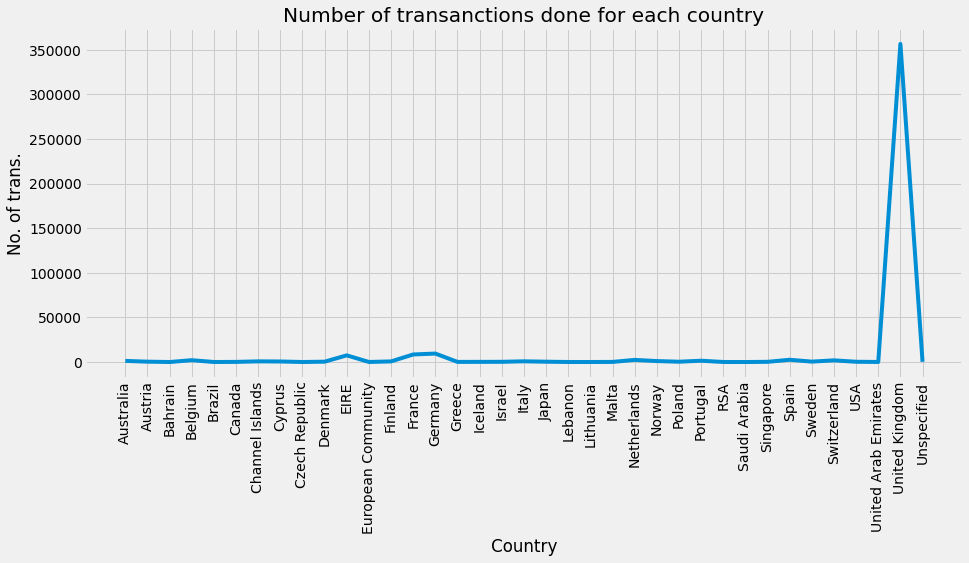

In [11]:
plt.figure(figsize=(14,6))
plt.plot(list(data.groupby(['Country']).groups.keys()), data.groupby(['Country'])['CustomerID'].count())
plt.xticks(rotation = 90, fontsize = 14)
plt.title("Number of transanctions done for each country")
plt.ylabel("No. of trans.")
plt.xlabel("Country")
plt.show()

In [12]:
info = pd.DataFrame(data = data.groupby(['Country'])['InvoiceNo'].nunique(), index=data.groupby(['Country']).groups.keys()).T
info

,Australia,Austria,Bahrain,Belgium,Brazil,Canada,Channel Islands,Cyprus,Czech Republic,Denmark,EIRE,European Community,Finland,France,Germany,Greece,Iceland,Israel,Italy,Japan,Lebanon,Lithuania,Malta,Netherlands,Norway,Poland,Portugal,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,United Kingdom,Unspecified
InvoiceNo,69,19,2,119,1,6,33,20,5,21,319,5,48,458,603,6,7,6,55,28,1,4,10,101,40,24,70,1,2,10,105,46,71,7,3,19857,8


** Conclusions **
1. UK has done most of the transanctions. (19857)
2. Least amount of transanctions were made by countries like Brazil, RSA etc. (only 1)

In [13]:
# StockCode Feature ->
# We will see how many different products were sold in the year data was collected.
print(len(data['StockCode'].value_counts()))

3684


In [14]:
# Transanction feature
# We will see how many different transanctions were done.
print(len(data['InvoiceNo'].value_counts()))

22190


In [15]:
# Transanction feature
# We will see how many different Customers are there.
print(len(data['CustomerID'].value_counts()))

4372


In [16]:
pd.DataFrame({'products':len(data['StockCode'].value_counts()),
              'transanctions':len(data['InvoiceNo'].value_counts()),
              'Customers':len(data['CustomerID'].value_counts())},
             index = ['Quantity'])

,products,transanctions,Customers
Quantity,3684,22190,4372


> There are 22k transanctions but only 4k customers with 3.5k products. It seems that some orders were placed then cancelled or the customers bought items multiple times or multiple items were bought in a single transanction.

##### Checking the number of items bought in a single transanctions :

In [17]:
df = data.groupby(['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
df = df.rename(columns = {'InvoiceDate':'Number of products'})
df[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346.0,541431,1
1,12346.0,C541433,1
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24
5,12347.0,556201,18
6,12347.0,562032,22
7,12347.0,573511,47
8,12347.0,581180,11
9,12348.0,539318,17


> There are customers who purchase only 1 item per transanction and others who purchase many items per transanction.
Also there are some orders which were cancelled they are marked with 'C' in the beginning.

##### Counting number of cancelled transanctions :

In [18]:
df['orders cancelled'] = df['InvoiceNo'].apply(lambda x: int('C' in str(x)))
df.head()

,CustomerID,InvoiceNo,Number of products,orders cancelled
0,12346.0,541431,1,0
1,12346.0,C541433,1,1
2,12347.0,537626,31,0
3,12347.0,542237,29,0
4,12347.0,549222,24,0


In [19]:
# Printing number of orders cancelled ->
print("Number of orders cancelled {}/{} ({:.2f}%)".format(df['orders cancelled'].sum(), df.shape[0], df['orders cancelled'].sum()/ df.shape[0] * 100))

Number of orders cancelled 3654/22190 (16.47%)


##### Handling Cancelled Values :

In [20]:
# Looking at cancelled transanctions in original data.
data.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347.0,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347.0,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347.0,Iceland


> We see that for every order that has to be cancelled a new transanction has to be sarted with different invoiceno, with negative quantity and every other description is same.
We can use this to remove the cancelled orders.

##### Checking for discounted products :

In [21]:
df = data[data['Description'] == 'Discount']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
9038,C537164,D,Discount,-1,2010-12-05 13:21:00,29.29,14527.0,United Kingdom
14498,C537597,D,Discount,-1,2010-12-07 12:34:00,281.00,15498.0,United Kingdom
19392,C537857,D,Discount,-1,2010-12-08 16:00:00,267.12,17340.0,United Kingdom
31134,C538897,D,Discount,-1,2010-12-15 09:14:00,5.76,16422.0,United Kingdom


> So there are some discounted transanctions too but they appear to be cancelled.

##### Checking whether every order that has been cancelled has a counterpart :

In [22]:
df = data[(data['Quantity']<0) & (data['Description']!='Discount')][['CustomerID','Quantity','StockCode','Description','UnitPrice']]
df.head()

,CustomerID,Quantity,StockCode,Description,UnitPrice
154,15311.0,-1,35004C,SET OF 3 COLOURED FLYING DUCKS,4.65
235,17548.0,-12,22556,PLASTERS IN TIN CIRCUS PARADE,1.65
236,17548.0,-24,21984,PACK OF 12 PINK PAISLEY TISSUES,0.29
237,17548.0,-24,21983,PACK OF 12 BLUE PAISLEY TISSUES,0.29
238,17548.0,-24,21980,PACK OF 12 RED RETROSPOT TISSUES,0.29


In [23]:
for index, col in df.iterrows():
    if data[(data['CustomerID'] == col[0]) & (data['Quantity'] == -col[1]) & (data['Description'] == col[2])].shape[0] == 0:
        print(index, df.loc[index])
        print("There are some transanctions for which counterpart does not exist")
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
There are some transanctions for which counterpart does not exist


We found out that there are some orders for which counterpart do not exist.
<br>
Reasons could be because some orders were made before the date the dataset is given from or that some orders were cancelled with exactly same counterpart or some are just errors maybe.

##### Removing cancelled orders :

In [24]:
df_cleaned = data.copy(deep=True)
df_cleaned['QuatityCancelled'] = 0
entry_to_remove = []; doubtfull_entry = []

for index, col in data.iterrows():
    if(col['Quantity'] > 0)or(col['Description']=='Discount'):continue
    df_test = data[(data['CustomerID']==col['CustomerID'])&(data['StockCode']==col['StockCode'])&
                   (data['InvoiceDate']<col['InvoiceDate'])&(data['Quantity']>0)].copy()
    
    # Order cancelled without counterpart, these are doubtful as they maybe errors or maybe orders were placed before data given
    if(df_test.shape[0] == 0):
        doubtfull_entry.append(index)
    
    # Cancellation with single counterpart
    elif(df_test.shape[0] == 1):
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCancelled'] = -col['Quantity']
        entry_to_remove.append(index)
        
    # Various counterpart exists for orders
    elif(df_test.shape[0] > 1):
        df_test.sort_index(axis = 0, ascending=False, inplace=True)
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']:continue
            df_cleaned.loc[ind, 'QuantityCancelled'] = -col['Quantity']
            entry_to_remove.append(index)
            break

In [25]:
print("Entry to remove {}".format(len(entry_to_remove)))
print("Doubtfull Entry {}".format(len(doubtfull_entry)))

Entry to remove 7521
Doubtfull Entry 1226


In [26]:
# Deleting these entries :
df_cleaned.drop(entry_to_remove, axis=0, inplace=True)
df_cleaned.drop(doubtfull_entry, axis=0, inplace=True)

##### We will now see the StockCode feature especially the discounted items:

In [27]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex = True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [28]:
for code in list_special_codes:
    print("{:<17} -> {:<35}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].values[0]))

POST              -> POSTAGE                            
D                 -> Discount                           
C2                -> CARRIAGE                           
M                 -> Manual                             
BANK CHARGES      -> Bank Charges                       
PADS              -> PADS TO MATCH ALL CUSHIONS         
DOT               -> DOTCOM POSTAGE                     


In [29]:
df_cleaned['QuantityCancelled'] = np.nan_to_num(df_cleaned['QuantityCancelled'])
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuatityCancelled,QuantityCancelled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,0.0


> We see that the same transanction is duplicated for every different item in the dataset. Like above invoice number 536365 the user probably purchased many different items and each have been given a row as shown. We will need to merge these so we will add the totalprice feature for each row.

##### Getting total data feature :

In [30]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCancelled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuatityCancelled,QuantityCancelled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,0,74215.0,0.0
148288,549222,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-04-07 10:43:00,4.25,12347.0,Iceland,0,0.0,17.0
428971,573511,22698,PINK REGENCY TEACUP AND SAUCER,12,2011-10-31 12:25:00,2.95,12347.0,Iceland,0,0.0,35.4
428970,573511,47559B,TEA TIME OVEN GLOVE,10,2011-10-31 12:25:00,1.25,12347.0,Iceland,0,0.0,12.5
428969,573511,47567B,TEA TIME KITCHEN APRON,6,2011-10-31 12:25:00,5.95,12347.0,Iceland,0,0.0,35.7


##### Now we sum the individual orders and group them on the basis of invoice number to remove the problem of duplicate rows for same order :

In [31]:
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice': 'Basket Price'})

df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace=True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
1,12347.0,537626,711.79,2010-12-07 14:57:00.000001024
2,12347.0,542237,475.39,2011-01-26 14:29:59.999999744
3,12347.0,549222,636.25,2011-04-07 10:42:59.999999232
4,12347.0,556201,382.52,2011-06-09 13:01:00.000000256
5,12347.0,562032,584.91,2011-08-02 08:48:00.000000000
6,12347.0,573511,1294.32,2011-10-31 12:25:00.000001280


##### Plotting the purchases made :

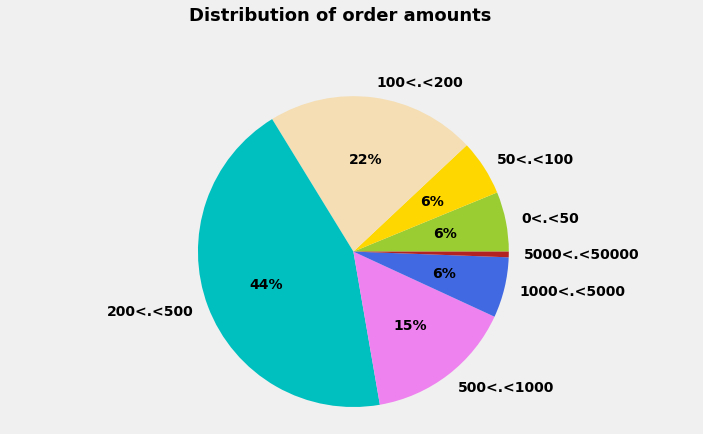

In [32]:
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i,price in enumerate(price_range):
    if i==0:continue
    val = basket_price[(basket_price['Basket Price'] < price)&
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)
    
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue', 'firebrick']
labels = ["{}<.<{}".format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels = labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle = 0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of order amounts", ha = 'center', fontsize = 18)
plt.show()

##### Analyzing product Description :

In [33]:
is_noun = lambda pos:pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    import nltk
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots = dict()
    keywords_select = dict()
    category_keys = []
    count_keywords = dict()
    icount = 0
    
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
        
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)
            
            category_keys.append(clef)
            keywords_select[s] = clef
        
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
            
    print("Number of keywords in the variable '{}': {}".format(colonne, len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [34]:
df_produits = pd.DataFrame(data['Description'].unique()).rename(columns = {0:"Description"})

In [35]:
import nltk
nltk.download('averaged_perceptron_tagger')
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
Number of keywords in the variable 'Description': 1483


In [36]:
# Plotting keywords vs frequency graph :
list_products = []
for k, v in count_keywords.items():
    word = keywords_select[k]
    list_products.append([word, v])

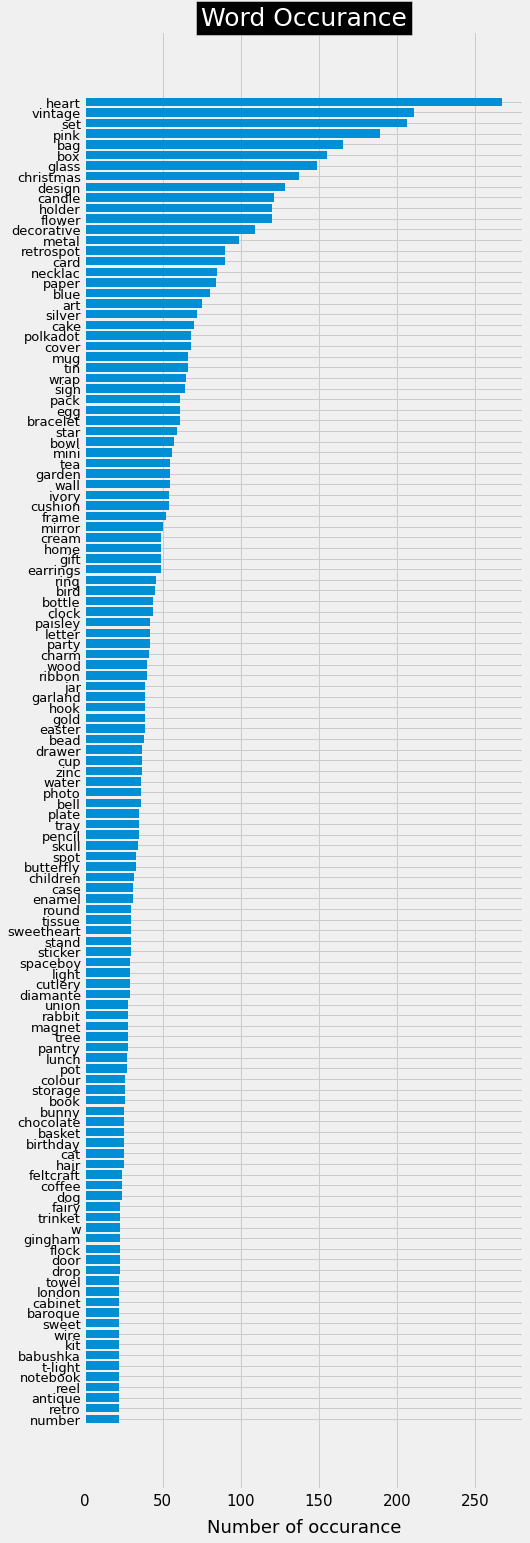

In [37]:
liste = sorted(list_products, key = lambda x:x[1], reverse=True)

plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
plt.yticks(x_axis, x_label)
plt.xlabel("Number of occurance", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align='center')
ax = plt.gca()
ax.invert_yaxis()

plt.title("Word Occurance", bbox={'facecolor':'k', 'pad':5}, color='w', fontsize = 25)
plt.show()

In [38]:
# Preserving important words :
list_products = []
for k, v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word)<3 or v<13: continue
    list_products.append([word, v])
    
list_products.sort(key = lambda x:x[1], reverse=True)
print("Number of preserved words : ", len(list_products))

Number of preserved words :  193


##### Descrining every product in terms of words present in the description :
1. We will only use the preserved words, this is just like Binary Bag of Words<br>
2. We need to convert this into a product matrix with products as rows and different words as columns. A cell contains a 1 if a particular product has that word in its description else it contains 0.
3. We will use this matrix to categorize the products.
4. We will add a mean price feature so that the groups are balanced.

In [39]:
threshold = [0, 1, 2, 3, 5, 10]

# Getting the description.
liste_produits = df_cleaned['Description'].unique()

# Creating the product and word matrix.
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))
    

label_col = []
for i in range(len(threshold)):
    if i == len(threshold) - 1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i], threshold[i+1])
        
    label_col.append(col)
    X.loc[:, col] = 0
    
for i, prod in enumerate(liste_produits):
    prix = df_cleaned[df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    
    while prix > threshold[j]:
        j += 1
        if j == len(threshold):
            break
    X.loc[i, label_col[j-1]] = 1

In [40]:
print("{:<8} {:<20} \n".format('range', 'number of products') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

range    number of products   
--------------------
0<.<1       964                 
1<.<2       1009                
2<.<3       673                 
3<.<5       606                 
5<.<10      470                 
.>10        156                 


### Clustering :
1. KMEANS.

In [41]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [42]:
matrix = X.values

In [43]:
# Using optimal number of clusters using hyperparameter tuning:
for n_clusters in range(3, 10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init = 30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    sil_avg = silhouette_score(matrix, clusters)
    print("For n_clusters : ", n_clusters, "The average silhouette_score is : ", sil_avg)

For n_clusters :  3 The average silhouette_score is :  0.10071681758064248
For n_clusters :  4 The average silhouette_score is :  0.12609893747265383
For n_clusters :  5 The average silhouette_score is :  0.1466257603527048
For n_clusters :  6 The average silhouette_score is :  0.14371323518203294
For n_clusters :  7 The average silhouette_score is :  0.1430369684296783
For n_clusters :  8 The average silhouette_score is :  0.14254726032406628
For n_clusters :  9 The average silhouette_score is :  0.15518355320236085


In [44]:
# Choosing number of clusters as 5:
# Trying Improving the silhouette_score :
n_clusters = 5
sil_avg = -1
while sil_avg < 0.145:
    kmeans = KMeans(init = 'k-means++', n_clusters = n_clusters, n_init = 30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    sil_avg = silhouette_score(matrix, clusters)
    print("For n_clusters : ", n_clusters, "The average silhouette_score is : ", sil_avg)

For n_clusters :  5 The average silhouette_score is :  0.1470081849157512


In [45]:
# Printing number of elements in each cluster :
pd.Series(clusters).value_counts()

3    1009
0     964
2     673
4     626
1     606
dtype: int64

#### Analyzing the 5 clusters :

In [46]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    import matplotlib as mpl
    mpl.rc('patch', edgecolor = 'dimgray', linewidth = 1)
    
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhoutte_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhoutte_values.sort()
        size_cluster_i = ith_cluster_silhoutte_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhoutte_values, alpha = 0.8)
        
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                 bbox = dict(facecolor = 'white', edgecolor = 'black', boxstyle = 'round, pad = 0.3'))
        
        y_lower = y_upper + 10

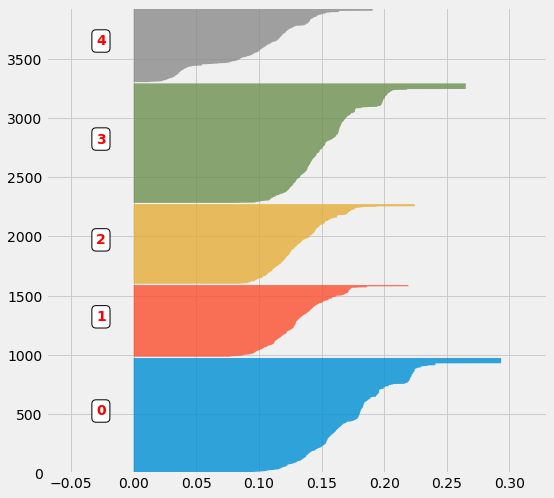

In [47]:
# Plotting the intra cluster silhouette distances.
from sklearn.metrics import silhouette_samples
sample_silhouette_values = silhouette_samples(matrix, clusters)
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

##### Analysis using wordcloud:
> Checking which words are most common in the clusters.

In [48]:
liste = pd.DataFrame(liste_produits)
liste_words = [word for (word, occurance) in list_products]

occurance = [dict() for _ in range(n_clusters)]

In [49]:
# Creating data for printing word cloud.
for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurance[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

In [50]:
# Code for printing word cloud.
from random import randint
import random
def random_color_func(word=None, font_size=None, position=None,orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

In [51]:
def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4, 2, increment)
    words = dict()
    trunc_occurances = liste[0:150]
    for s in trunc_occurances:
        words[s[0]] = s[1]
        
    wc = wordcloud.WordCloud(width=1000,height=400, background_color='lightgrey', max_words=1628,relative_scaling=1,
                             color_func = random_color_func, normalize_plurals=False)
    wc.generate_from_frequencies(words)
    ax1.imshow(wc, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster n{}'.format(increment-1))

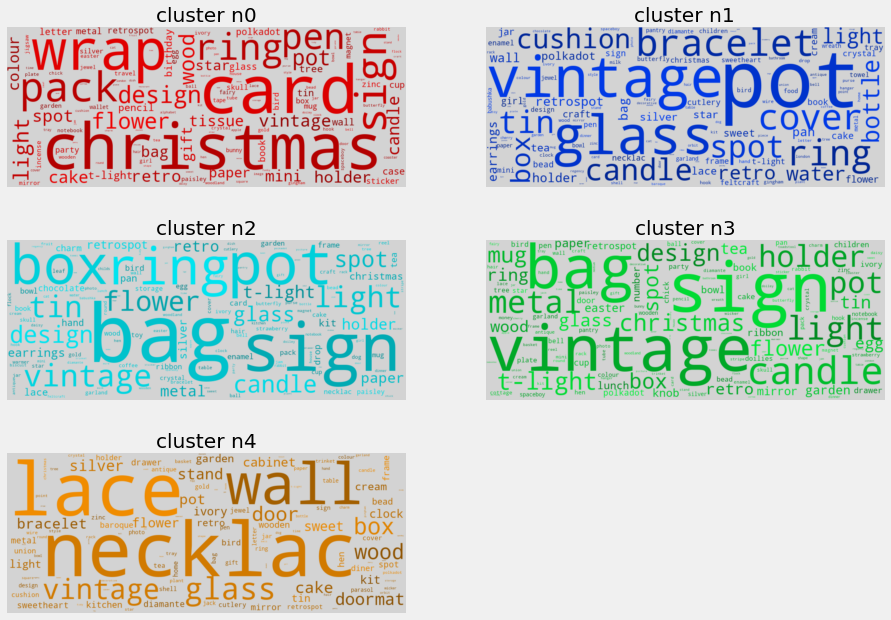

In [52]:
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurance[i]
    tone = color[i]
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)

** Conclusions **
1. Cluster number two contains all the items related to decoration and gifts.
2. Cluster number 4 contains luxury items.
3. Words like Vintage are common to most of the clusters.

## Dimensionality Reduction:
> PCA

In [53]:
from sklearn.decomposition import PCA

In [54]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


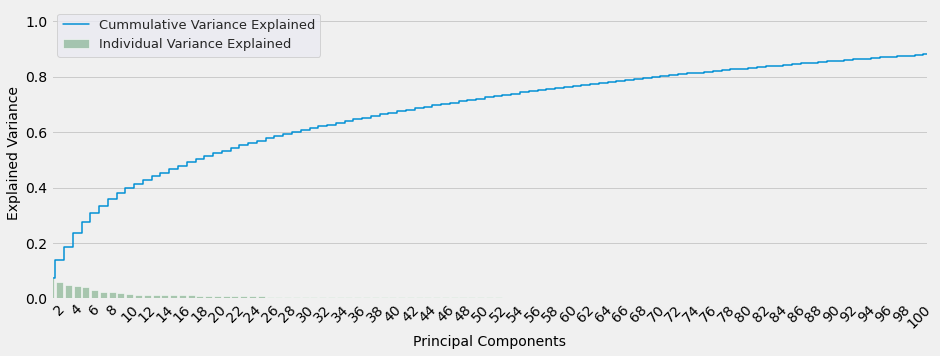

In [55]:
# Checking the amount of variance explained :
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where = 'mid', label = 'Cummulative Variance Explained')
sns.barplot(np.arange(1, matrix.shape[1] + 1), pca.explained_variance_ratio_, alpha = 0.5, color = 'g',
            label = 'Individual Variance Explained')
plt.xlim(0, 100)
plt.xticks(rotation = 45, fontsize = 14)
ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel("Explained Variance", fontsize = 14)
plt.xlabel("Principal Components", fontsize = 14)
plt.legend(loc = 'upper left', fontsize = 13)
plt.show()

** We need more than 100 Principal Components to explain more than 90 % of the variance. **
<br>

## Generating Customer Segments/Categories :
1. We will use the already generated product categories and create a new feature which tells to which category the product belongs to.

In [56]:
corresp = dict()
for key, val in zip(liste_produits, clusters):
    corresp[key] = val
    
df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)
df_cleaned[['InvoiceNo', 'Description', 'categ_product']][:10]

,InvoiceNo,Description,categ_product
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,2
1,536365,WHITE METAL LANTERN,1
2,536365,CREAM CUPID HEARTS COAT HANGER,1
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,1
4,536365,RED WOOLLY HOTTIE WHITE HEART.,1
5,536365,SET 7 BABUSHKA NESTING BOXES,4
6,536365,GLASS STAR FROSTED T-LIGHT HOLDER,1
7,536366,HAND WARMER UNION JACK,2
8,536366,HAND WARMER RED POLKA DOT,3
9,536367,ASSORTED COLOUR BIRD ORNAMENT,3


In [57]:
# Creating 5 new features that will contain the amount in a single transanction on different categories of product.
for i in range(5):
    col = 'categ_{}'.format(i)
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCancelled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)
    
df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']][:10]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,2,0.0,0.00,15.3,0.00,0.0
1,536365,WHITE METAL LANTERN,1,0.0,20.34,0.0,0.00,0.0
2,536365,CREAM CUPID HEARTS COAT HANGER,1,0.0,22.00,0.0,0.00,0.0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,1,0.0,20.34,0.0,0.00,0.0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,1,0.0,20.34,0.0,0.00,0.0
5,536365,SET 7 BABUSHKA NESTING BOXES,4,0.0,0.00,0.0,0.00,15.3
6,536365,GLASS STAR FROSTED T-LIGHT HOLDER,1,0.0,25.50,0.0,0.00,0.0
7,536366,HAND WARMER UNION JACK,2,0.0,0.00,11.1,0.00,0.0
8,536366,HAND WARMER RED POLKA DOT,3,0.0,0.00,0.0,11.10,0.0
9,536367,ASSORTED COLOUR BIRD ORNAMENT,3,0.0,0.00,0.0,54.08,0.0


##### A single order is split into multiple entries we will basket them :

In [58]:
# sum of purchases by user and order.
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index = False)['TotalPrice'].sum()
basket_price = temp.rename(columns={'TotalPrice': 'Basket Price'})

# percentage spent on each product category 
for i in range(5):
    col = "categ_{}".format(i)
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index = False)[col].sum()
    basket_price.loc[:, col] = temp

# Dates of the order.
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index = False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace=True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

# Selecting entries with basket price > 0.
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending=True)[:5]

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
1,12347.0,537626,711.79,23.40,293.35,83.40,187.2,124.44,2010-12-07 14:57:00.000001024
2,12347.0,542237,475.39,84.34,169.20,53.10,130.5,38.25,2011-01-26 14:29:59.999999744
3,12347.0,549222,636.25,81.00,115.00,71.10,330.9,38.25,2011-04-07 10:42:59.999999232
4,12347.0,556201,382.52,41.40,168.76,78.06,74.4,19.90,2011-06-09 13:01:00.000000256
5,12347.0,562032,584.91,61.30,158.16,119.70,109.7,136.05,2011-08-02 08:48:00.000000000


In [59]:
basket_price['InvoiceDate'].min()

Timestamp('2010-12-01 08:26:00')

In [60]:
basket_price['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

##### Time Based Splitting :

In [61]:
import datetime
set_entrainment = basket_price[basket_price['InvoiceDate'] < np.datetime64('2011-10-01')]
set_test = basket_price[basket_price['InvoiceDate'] >=np.datetime64('2011-10-01')]
basket_price = set_entrainment.copy(deep = True)

##### Grouping Orders :
> We will get info about every customer on how much do they purchase, total number of orders. etc

In [62]:
transanctions_per_user = basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count', 'min', 'max', 'mean', 'sum'])

for i in range(5):
    col = 'categ_{}'.format(i)
    transanctions_per_user.loc[:, col] = basket_price.groupby(by=['CustomerID'])[col].sum() / transanctions_per_user['sum'] * 100
    
transanctions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transanctions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347.0,5,382.52,711.79,558.172000,2790.86,10.442659,32.408290,14.524555,29.836681,12.787815
1,12348.0,4,227.44,892.80,449.310000,1797.24,38.016069,0.000000,0.000000,41.953217,20.030714
2,12350.0,1,334.40,334.40,334.400000,334.40,11.692584,0.000000,27.900718,48.444976,11.961722
3,12352.0,6,144.35,840.30,345.663333,2073.98,0.491808,15.711338,3.370331,12.892120,67.534402
4,12353.0,1,89.00,89.00,89.000000,89.00,0.000000,0.000000,19.887640,13.033708,67.078652


In [63]:
# Generating two new variables - days since first puchase and days since last purchase.
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transanctions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transanctions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

In [64]:
transanctions_per_user[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347.0,5,382.52,711.79,558.172000,2790.86,10.442659,32.408290,14.524555,29.836681,12.787815,59,297
1,12348.0,4,227.44,892.80,449.310000,1797.24,38.016069,0.000000,0.000000,41.953217,20.030714,5,288
2,12350.0,1,334.40,334.40,334.400000,334.40,11.692584,0.000000,27.900718,48.444976,11.961722,240,240
3,12352.0,6,144.35,840.30,345.663333,2073.98,0.491808,15.711338,3.370331,12.892120,67.534402,2,226
4,12353.0,1,89.00,89.00,89.000000,89.00,0.000000,0.000000,19.887640,13.033708,67.078652,134,134


##### We need to focus on customers who only placed one order, our objective is to target these customers in a way to retains them.

In [65]:
n1 = transanctions_per_user[transanctions_per_user['count'] == 1].shape[0]
n2 = transanctions_per_user.shape[0]
print("No. of Customers with single purchase : {:<2}/{:<5} ({:<2.2f}%)".format(n1, n2, n1/n2*100))

No. of Customers with single purchase : 1445/3608  (40.05%)


##### Building Customer Segments :

In [66]:
list_cols = ['count', 'min', 'max', 'mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
selected_customers = transanctions_per_user.copy(deep=True)
matrix = selected_customers[list_cols].values

In [67]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(matrix)
print("Variable Mean Values: \n" + 90*'-' + '\n', scaler.mean_)
scaled_matrix = scaler.transform(matrix)

Variable Mean Values: 
------------------------------------------------------------------------------------------
 [  3.62305987 259.93189634 556.26687999 377.06036244  13.98907929
  16.37327913  21.19884856  25.22916919  23.21847344]


In [68]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


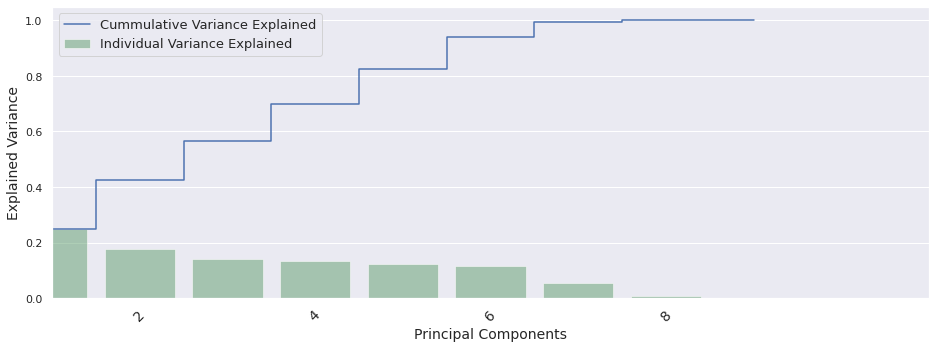

In [69]:
# Checking the amount of variance explained :
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where = 'mid', label = 'Cummulative Variance Explained')
sns.barplot(np.arange(1, matrix.shape[1] + 1), pca.explained_variance_ratio_, alpha = 0.5, color = 'g',
            label = 'Individual Variance Explained')
plt.xlim(0, 10)
plt.xticks(rotation = 45, fontsize = 14)
ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel("Explained Variance", fontsize = 14)
plt.xlabel("Principal Components", fontsize = 14)
plt.legend(loc = 'upper left', fontsize = 13)
plt.show()

In [70]:
# Using optimal number of clusters using hyperparameter tuning:
for n_clusters in range(3, 21):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init = 30)
    kmeans.fit(scaled_matrix)
    clusters = kmeans.predict(scaled_matrix)
    sil_avg = silhouette_score(scaled_matrix, clusters)
    print("For n_clusters : ", n_clusters, "The average silhouette_score is : ", sil_avg)

For n_clusters :  3 The average silhouette_score is :  0.159589927965517
For n_clusters :  4 The average silhouette_score is :  0.15234147757690125
For n_clusters :  5 The average silhouette_score is :  0.1608651422819699
For n_clusters :  6 The average silhouette_score is :  0.1776536477549887
For n_clusters :  7 The average silhouette_score is :  0.19399713307860206
For n_clusters :  8 The average silhouette_score is :  0.20437731795457467
For n_clusters :  9 The average silhouette_score is :  0.2062824165496336
For n_clusters :  10 The average silhouette_score is :  0.21146700113670494
For n_clusters :  11 The average silhouette_score is :  0.21671939890416153
For n_clusters :  12 The average silhouette_score is :  0.18671054626066125
For n_clusters :  13 The average silhouette_score is :  0.1885589266793072
For n_clusters :  14 The average silhouette_score is :  0.19035608563355977
For n_clusters :  15 The average silhouette_score is :  0.19353614610364647
For n_clusters :  16 The 

In [71]:
# Choosing number of clusters as 10:
# Trying Improving the silhouette_score :
n_clusters = 10
sil_avg = -1
while sil_avg < 0.208:
    kmeans = KMeans(init = 'k-means++', n_clusters = n_clusters, n_init = 30)
    kmeans.fit(scaled_matrix)
    clusters = kmeans.predict(scaled_matrix)
    sil_avg = silhouette_score(scaled_matrix, clusters)
    print("For n_clusters : ", n_clusters, "The average silhouette_score is : ", sil_avg)

For n_clusters :  10 The average silhouette_score is :  0.21282020923652417


In [72]:
n_clusters = 10
kmeans = KMeans(init = 'k-means++', n_clusters = n_clusters, n_init = 100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print("Silhouette Score : {:<.3f}".format(silhouette_avg))

Silhouette Score : 0.213


In [73]:
# Looking at clusters :
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns=['Number of Clients']).T

,0,5,2,4,1,9,8,7,3,6
Number of Clients,1507,530,477,319,300,233,197,22,12,11


> There is a large difference in cluster segments, We will analyze these clusters further.

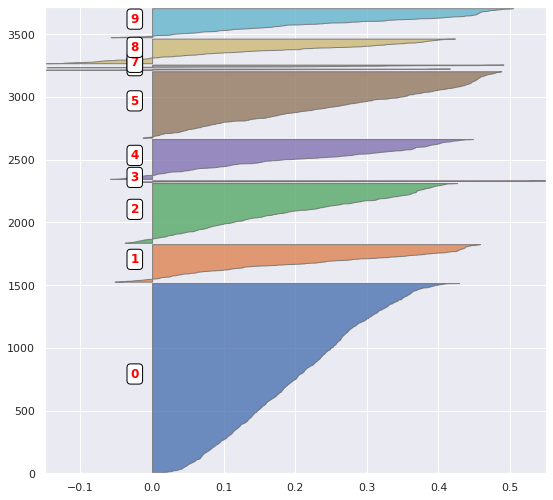

In [74]:
sample_silhouette_values = sklearn.metrics.silhouette_samples(scaled_matrix, clusters_clients)

graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

From this above graph we can rest assured that all the clusters are disjoint

##### Now we need to learn the habits of the customers to do that we will add the variables that define a cluster to which each customer belong:

In [75]:
selected_customers.loc[:, 'cluster'] = clusters_clients

In [76]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
    
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('Number of customers : ', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

Number of customers :  3608


In [78]:
# Reorganizing the content of the dataframe.
liste_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    liste_index.append(merged_df[merged_df[column] > 45].index.values[0])
    
liste_index_reordered = liste_index
liste_index_reordered += [s for s in merged_df.index if s not in liste_index]

merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
merged_df.head()

,index,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase,size
0,0,9.0,2.167382,193.670773,316.038283,246.328299,574.800086,57.370116,6.095289,11.031165,18.007631,7.495799,99.120172,166.618026,233
1,1,4.0,2.128527,206.417586,349.722947,266.745559,678.264263,6.554914,49.858987,13.948450,13.443540,16.242664,109.645768,168.830721,319
2,2,1.0,2.973333,206.712300,402.043800,294.069689,1014.570967,6.974821,7.045440,60.826853,14.905190,10.247695,101.443333,197.753333,300
3,3,2.0,2.484277,216.301468,334.196354,272.052410,710.485222,13.085109,7.859064,12.940634,56.699586,9.418728,102.280922,174.125786,477
4,4,5.0,2.784906,199.898115,354.122566,263.667723,786.884964,4.911707,11.167613,11.176829,11.268022,61.486476,114.296226,188.586792,530


##### Saving the selected customer dataframe and above dataframe to csv so that we do not need to do all this again :

In [79]:
selected_customers.to_csv("selected_customers.csv")

In [80]:
merged_df.to_csv("merged_df.csv")

## Classifying the Customers :

In [81]:
selected_customers = pd.read_csv('selected_customers.csv')
merged_df = pd.read_csv('merged_df.csv')

##### Defining Helper Functions :

In [82]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
class Class_Fit(object):
    def __init__(self, clf, params = None):
        if params:
            self.clf = clf(**params)
        else:
            self.clf = clf()
            
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} %".format(100 * accuracy_score(Y, self.predictions)))

In [83]:
selected_customers.head()

,Unnamed: 0,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase,cluster
0,0,12347.0,5,382.52,711.79,558.172000,2790.86,10.442659,32.408290,14.524555,29.836681,12.787815,59,297,0
1,1,12348.0,4,227.44,892.80,449.310000,1797.24,38.016069,0.000000,0.000000,41.953217,20.030714,5,288,2
2,2,12350.0,1,334.40,334.40,334.400000,334.40,11.692584,0.000000,27.900718,48.444976,11.961722,240,240,2
3,3,12352.0,6,144.35,840.30,345.663333,2073.98,0.491808,15.711338,3.370331,12.892120,67.534402,2,226,5
4,4,12353.0,1,89.00,89.00,89.000000,89.00,0.000000,0.000000,19.887640,13.033708,67.078652,134,134,5


In [84]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
X = selected_customers[columns]
Y = selected_customers['cluster']

##### Train, Test Splitting :

In [85]:
from sklearn.model_selection import train_test_split

In [86]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8)

### Training Models :

In [87]:
from sklearn.svm import LinearSVC

In [88]:
svc = Class_Fit(clf=LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10),'dual':[False]}], Kfold = 5)

In [89]:
svc.grid_fit(X=X_train, Y=Y_train)

In [90]:
svc.grid_predict(X_test, Y_test)

Precision: 88.92 %


In [91]:
from sklearn.metrics import confusion_matrix

In [92]:
# code from -> SKLEARN Documentation.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[305   1   1   0   0   1   0   0   0   0]
 [  3  45   0   0   0   0   0   0   0   0]
 [  8   0  85   0   0   1   0   0   0   0]
 [  0   0   0   0   0   0   0   0   4   1]
 [ 10   0   0   0  63   0   0   0   0   0]
 [ 10   0   0   0   0  93   0   0   0   0]
 [  0   0   0   0   0   0   0   0   4   0]
 [  3   1   0   0   0   1   0   0   0   0]
 [ 25   0   0   0   0   1   0   0  15   2]
 [  3   0   0   0   0   0   0   0   0  36]]


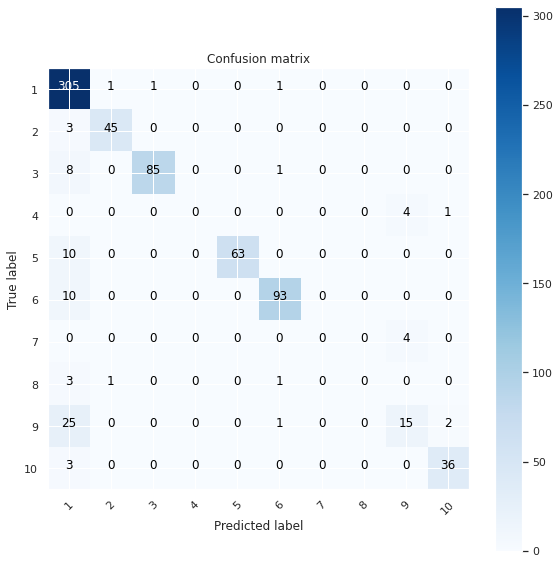

In [93]:
class_names = [i for i in range(1,11)]
cnf = confusion_matrix(Y_test, svc.predictions)
np.set_printoptions(precision=2)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

In [94]:
# Code from sklearn documentation.
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

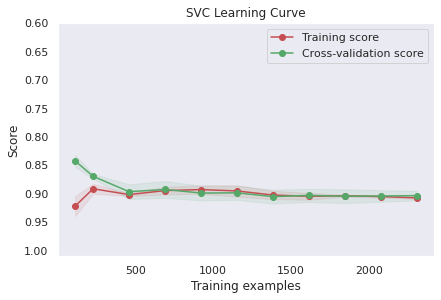

In [95]:
g = plot_learning_curve(svc.grid.best_estimator_, "SVC Learning Curve", X_train, Y_train, ylim=[1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])